# Real or Fake?

In this notebook I show three different solutions for the ["Real or Not Real or Not? NLP with Disaster Tweets
"](https://www.kaggle.com/c/nlp-getting-started/overview) Kaggle practice competition. The three approaches I use for classifying whether a tweet is about a real disaster or not are the following: Naive Bayes, Random Forest Classifier on Doc2Vec embeddings, and LSTM on GloVe embeddings. 

## Table of Contents

* [1 Preparations](#prep)
* [2 Data Cleaning](#clean)
* [3 Models for Classification](#models)
    * [3.1 Naive Bayes Classifier](#NBC)
    * [3.2 Random Forest on Doc2Vec embeddings](#RF)
    * [3.2 LSTM on GloVe embeddings](#LSTM)     
* [4 Submission](#submission)



## 1. Preparations <a class="anchor" id="prep"></a>

In [1]:
# Importing all kinds of packages, in no particular order

# Basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Data cleaning:
import re
from collections import Counter 
import nltk
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer
import string
from spellchecker import SpellChecker
# Modeling basics:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
# For D2V + RF:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import multiprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn import utils
# For Glove + LSTM:
from keras.preprocessing.text import Tokenizer
from keras.layers import LSTM,Dense,Dropout,Embedding,Bidirectional
from keras.preprocessing.sequence import pad_sequences
from keras import Sequential
from tqdm import tqdm

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/matevaradi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Using TensorFlow backend.
/Users/matevaradi/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/matevaradi/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/matevaradi/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future ver

In [2]:
# Load data
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

In [3]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


The target takes the value 1 when the tweet is about a real disaser and 0 otherwise.

In [4]:
print("Number of tweets in training data: ",train.shape[0])
print("Number of tweets about real disasters in training data: ", sum(train.target))
print("Number of tweets about fake disasters in training data: ", sum(train.target==0))
print("Number of tweets in test data: ",test.shape[0])

Number of tweets in training data:  7613
Number of tweets about real disasters in training data:  3271
Number of tweets about fake disasters in training data:  4342
Number of tweets in test data:  3263


The dataset is not too imbalanced, but there are slightly more fake disaster tweets than real ones. 

In [5]:
print("Examples of real disaster tweets: \n")
for tweet in train[train.target==1].sample(3)["text"]:
    print(tweet)
    print("\n")
print("____________________________ \n")
print("Examples of not real disaster tweets: \n")
for tweet in train[train.target==0].sample(3)["text"]:
    print(tweet)
    print("\n")

Examples of real disaster tweets: 

@UN No more #GujaratRiot &amp; #MumbaiRiot92-93 which devastated 1000&amp;1000 Indianperpetrated by #Modi &amp; #ChawalChorbjp @UN_Women  @UNNewsTeam


#DebateQuestionsWeWantToHear If U start another war would U B willing 2 go 2 the war-zone yourself or send UR sons and/or daughters 2 fight?


OUN cancels Severe Thunderstorm Warning for Lincoln Logan Oklahoma [OK]  http://t.co/bTi8JAMFiu #WX


____________________________ 

Examples of not real disaster tweets: 

I liked a @YouTube video http://t.co/N95IGskd3p Minecraft: Episode 2 'Blaze Farm Beginnings!'


I hope you fall off a cliff


The Twitter update pretty much wrecked the app




In [6]:
indices=np.arange(train.shape[0])
np.random.shuffle(indices)

print("Size of original training set:",train.shape[0])

# Let's split our data into a training and a validation set
val=train.iloc[indices[0:1500]] 
train=train.iloc[indices[1500:]]

print("Size of new training set:",train.shape[0])
print("Size of validation set:",val.shape[0])

Size of original training set: 7613
Size of new training set: 6113
Size of validation set: 1500


## 2. Data Cleaning <a class="anchor" id="clean"></a>

In [7]:
example_tweet="OMG this vid is SoO funny!!! 4 :) http://www.youtube.com/watch?v=_Vaasd332a #youtube"

For simplicity we will use the same cleaning steps for all of our models. These will be the following:

1. Make text lowercase
2. Remove hashtags, hyperlinks and Twitter marks
3. Tokenization - Converting a sentence into list of words
4. Remove stopwords and punctuations
5. Spell checking - correcting mispelled words (optional, as it takes a lot of time to run)
6. Lemmetization/stemming - Tranforming any form of a word to its root word

#### Step 1: Make text lowercase

In [8]:
train["text"]=train["text"].apply(lambda x: x.lower())
val["text"]=val["text"].apply(lambda x: x.lower())
test["text"]=test["text"].apply(lambda x: x.lower())

#### Step 2: Remove hashtags, hyperlinks and retweet signs
We do not want to treat individual hyperlinks as a separate term of the vocabulary, but the fact the the tweet contains a link may be relevant. The same goes for all digits and the (old) retweet sign as well. 

In [9]:
def remove_things(tweet):
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)

    # replace hyperlinks with the word "hyperlink"
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', 'hyperlink', tweet)
    
    # replace digits with the word "digit"
    tweet = re.sub(r'[0-9]+', 'digit', tweet)

    # remove hashtags (only removing the hash # sign from the word)
    tweet = re.sub(r'#', 'retweet', tweet)

    return tweet

In [10]:
remove_things(example_tweet)

'OMG this vid is SoO funny!!! digit :) hyperlink'

In [11]:
train["text"]=train["text"].apply(lambda x: remove_things(x))
val["text"]=val["text"].apply(lambda x: remove_things(x))
test["text"]=test["text"].apply(lambda x: remove_things(x))

#### Step 3: Tokenization

In [12]:
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)

# Create a list of tokenized tweets
train_tweetlist=[]
val_tweetlist=[]
test_tweetlist=[]

# Run tokenization in all 3 subsets of our data:
for tweet in train["text"]:
    tokenized_tweet=tokenizer.tokenize(tweet)
    train_tweetlist.append(tokenized_tweet)

for tweet in val["text"]:
    tokenized_tweet=tokenizer.tokenize(tweet)
    val_tweetlist.append(tokenized_tweet)
    
for tweet in test["text"]:
    tokenized_tweet=tokenizer.tokenize(tweet)
    test_tweetlist.append(tokenized_tweet)

#### Step 4: Removing stopwords and punctuation

In [13]:
def remove_punct_and_stopwords(tweet_tokens, 
                            punct_to_remove=string.punctuation,
                            stopwords_to_remove=nltk.corpus.stopwords.words('english')):
    cleaned_tweet=[]
    for word in tweet_tokens: # Go through every word in your tokens list
        if (word not in stopwords_to_remove and  # remove stopwords
            word not in punct_to_remove):  # remove punctuation
            cleaned_tweet.append(word)
    return cleaned_tweet

In [14]:
train_tweetlist=list(map(remove_punct_and_stopwords, train_tweetlist))
val_tweetlist=list(map(remove_punct_and_stopwords, val_tweetlist))
test_tweetlist=list(map(remove_punct_and_stopwords, test_tweetlist))

#### Step 5: Spell checking

In [15]:
spell = SpellChecker()
def correct_spellings(tweet_tokens):
    corrected_text = []
    misspelled_words = spell.unknown(tweet_tokens)
    for token in tweet_tokens:
        if token in misspelled_words:
            corrected_text.append(spell.correction(token))
        else:
            corrected_text.append(token)
    return " ".join(corrected_text)

In [16]:
correct_spellings(["niec","gramarr","proces"])

'nice grammar process'

We will skip this spell checking test as it takes a lot of time to run.


#### Step 6: Lemmatization
Lemmatization means trimming words into a common root. This is usually done before running most NLP tasks.

In [17]:
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize_tweet(tweet_tokens):
    return [wordnet_lemmatizer.lemmatize(token) for token in tweet_tokens]

In [18]:
train_tweetlist=list(map(lemmatize_tweet, train_tweetlist))
val_tweetlist=list(map(lemmatize_tweet, val_tweetlist))
test_tweetlist=list(map(lemmatize_tweet, test_tweetlist))

## 3. Models for classification <a class="anchor" id="models"></a>
### 3.1 Naive Bayes Classifier <a class="anchor" id="NBC"></a>

This implementation is taken from the Week 2 of Course 1 of the [NLP Specialization of deeplearning.ai on Coursera](https://www.coursera.org/specializations/natural-language-processing). For the explanations I used [this summary](https://web.stanford.edu/~jurafsky/slp3/4.pdf) of Naive Bayes Classifiers. 

In a Naive Bayes model we work with both the bag-of-words and the naive Bayes assumptions. The latter means that the words (features $f_1 ... f_n$) within a document are independent of each other given their class $c$:

$P\left(f_{1}, f_{2}, \ldots, f_{n} \mid c\right)=P\left(f_{1} \mid c\right) \cdot P\left(f_{2} \mid c\right) \cdot \ldots \cdot P\left(f_{n} \mid c\right)$

The Naive Bayes classifier chooses the most probable class for each document $d$ given this independence assumption:

$c_{N B}=\underset{c \in C}{\operatorname{argmax}} P(c) \prod_{f \in F} P(f \mid c).$

As usual, to avoid underflow problems, we use logs in calculations:

$c_{N B}=\underset{c \in C}{\operatorname{argmax}}\ \log P(c)+\sum_{i \in \text {positions}} \log P\left(w_{i} \mid c\right)$

$P(c)$ here is the prior probability for belonging to class $c$, which is given in our case by the proportion of real disaster tweets for the *real* class and vice versa for the *fake* class. $P\left(w_{i} \mid c\right)$ is the probability of a word appearing in class $c$. To calculate these probabilities for each class, first we will go through our tweets and count how frequently their words appear in both real and fake tweets.

In [19]:
def count_tweets(tweets, ys):
    '''
    Input:
        tweets: a list of (processed) tweets
        ys: a list corresponding to the sentiment of each tweet (either 0 or 1)
    Output:
        result: a dictionary mapping each pair to its frequency
    ''' 
    result={} 
    
    for y, tweet in zip(ys, tweets):     # loop through tweets
        for word in tweet: # loop through words
            # define the key, which is the word and label tuple
            pair = (word,y)

            # if the key exists in the dictionary, increment the count
            if pair in result:
                result[pair] += 1

            # else, if the key is new, add it to the dictionary and set the count to 1
            else:
                result[pair] = 1
    return result

In [20]:
ys=list(train.target)
real_fake_freqs=count_tweets(train_tweetlist,ys)

In [21]:
# Let's look at an example of our count dictionary
print(real_fake_freqs[("disaster",1)])
print(real_fake_freqs[("disaster",0)])

88
32


In [22]:
k = Counter(real_fake_freqs) 
high_freq=k.most_common(100)
# Finding most common (actual) words in each class
top_unigram_counts_real=[h[1] for h in high_freq if h[0][1]==1][4:24]
top_unigrams_real=[h[0][0] for h in high_freq if h[0][1]==1][4:24]
top_unigram_counts_fake=[h[1] for h in high_freq if h[0][1]==0][4:24]
top_unigrams_fake=[h[0][0] for h in high_freq if h[0][1]==0][4:24]

Text(0.5, 1.0, 'Top 20 most common unigrams in Non-disaster Tweets')

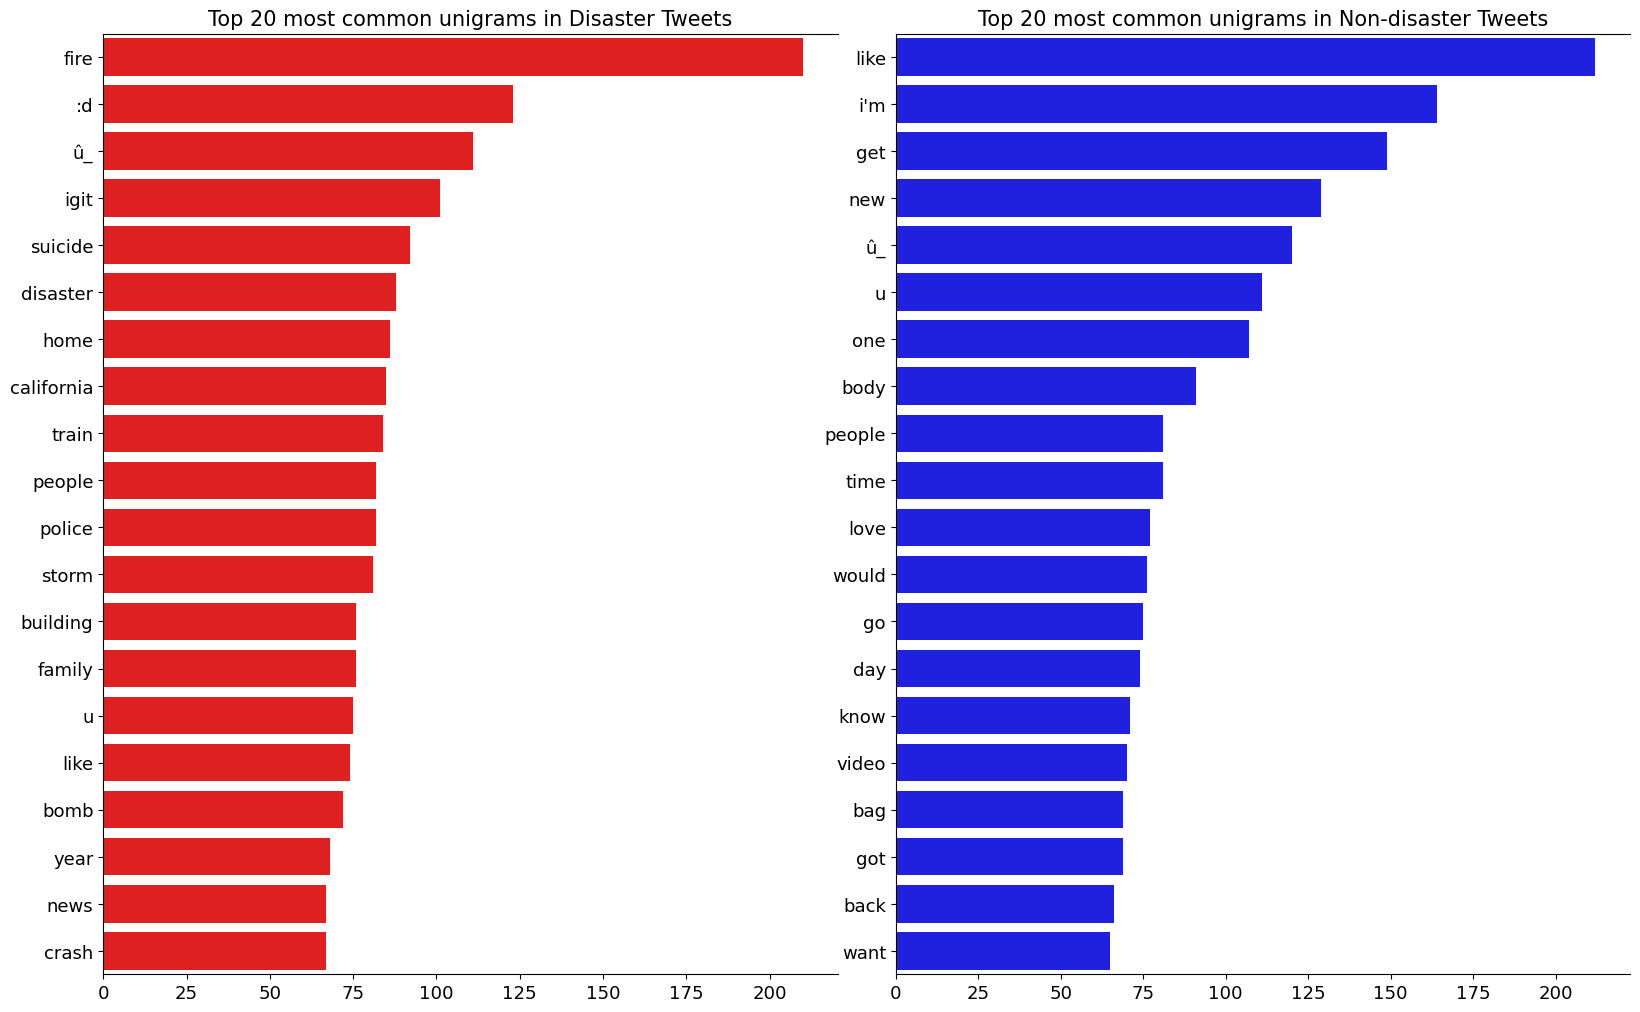

In [23]:
# Let's plot the most common words within each class 
fig, axes = plt.subplots(ncols=2, figsize=(16, 10), dpi=100)
plt.tight_layout()

sns.barplot(x=top_unigram_counts_real,y=top_unigrams_real,color='red',ax=axes[0])
sns.barplot(x=top_unigram_counts_fake,y=top_unigrams_fake,color='blue',ax=axes[1])

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {20} most common unigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {20} most common unigrams in Non-disaster Tweets', fontsize=15)

#### Training Naive Bayes Classifier

Notation:
* $c$ : class (*real* or *fake*)
* $W$: vocabulary, or set of unique words in dictionary
* $V=|W|$ : number of unique words in dictionary
* $N_{real}$, $N_{fake}$ : number of words that appear in real and fake tweets respectively
* $D$ : number of documents
* $D_{real}$, $D_{fake}$ : the number of real and fake documents respectively

As mentioned above, we can estimate the prior $P(c)$ of class *real* by $\hat{P}(real)=\frac{D_{real}}{D}$.

To estimate $P\left(w_{i} \mid c\right)$ we use the counts we just stored in a dictionary:

$\hat{P}\left(w_{i} \mid c\right)=\frac{\operatorname{count}\left(w_{i}, c\right)+1}{\sum_{w \in W}(\operatorname{count}(w, c)+1)}=\frac{\operatorname{count}\left(w_{i}, c\right)+1}{\left(\sum_{w \in W} \operatorname{count}(w, c)\right)+W}$,

where adding one to the numerator is called Laplace (or add-one) smooting and is necessary to avoid multipliaction by 0 when a word is not present in class.

For example if we wish to calculate the probability that the word "disaster" belongs to the *real* class:

$P("disaster"|c=real)=\frac{count("disaster"|real)+1}{N_{real}+W}$.

In training we go through each word and calculate the probabilty that it belongs to each class. We take and store these log ratio of these probabilites, $\log \frac{\hat{P}\left(w_{i} \mid c=real\right)}{\hat{P}\left(w_{i} \mid c=fake\right)}$. Similary for the log prior, we store $\log \frac{\hat{P}(c=real)}{\hat{P}(c=fake)}.$ 

In [24]:
def train_naive_bayes(freqs, train_x, train_y):
    '''
    Input:
        freqs: dictionary from (word, label) to how often the word appears
        train_x: a list of tweets
        train_y: a list of labels correponding to the tweets (0,1)
    Output:
        logprior: the log prior. (equation 3 above)
        loglikelihood: the log likelihood of you Naive bayes equation. (equation 6 above)
    '''
    loglikelihood = {}
    logprior = 0

    # calculate V
    vocab = set([pair[0] for pair in freqs.keys()])
    V = len(vocab)

    # calculate N_real, N_fake, V_real, V_fake
    N_real = N_fake = V_real = V_fake = 0
    for pair in freqs.keys():
        # if the label is positive (real)
        if pair[1] > 0:
            # Increment the number of positive words by the count for this (word, label) pair
            N_real += freqs[pair]

        # else, the label is negative (fake)
        else:
            # increment the number of negative words by the count for this (word,label) pair
            N_fake += freqs[pair]

    # Calculate D, the number of documents
    D = len(train_y)

    # Calculate D_real and D_fake
    D_real = sum(train_y)
    D_fake = D-D_real
    
    # Calculate logprior
    logprior = np.log(D_real) - np.log(D_fake)

    # Calculate the loglikelihood for each word in the vocabulary...
    for word in vocab:
        # get the real and fake frequency of the word
        freq_real = real_fake_freqs.setdefault((word,1),0)
        freq_fake = real_fake_freqs.setdefault((word,0),0)

        # calculate the probability that each word is positive, and negative
        p_w_real = (freq_real + 1) / (N_real + V)
        p_w_fake = (freq_fake + 1) / (N_fake + V)

        # calculate the log likelihood of the word
        loglikelihood[word] = np.log(p_w_real/p_w_fake)

    return logprior, loglikelihood

In [25]:
logprior, loglikelihood = train_naive_bayes(real_fake_freqs, train_tweetlist, ys)
print(logprior)

-0.2749066102977267


The negative prior means that there given no other information we expect that a random tweet is more likely to be about a non-real disaster than a real one. This is simply because there are more fake disaster tweets in the training data than real ones.

When predicting a class for a new tweet we use the formula:

$\log \frac{\hat{P}(c=real)}{\hat{P}(c=fake)}+\sum_w \log \frac{\hat{P}\left(w \mid c=real\right)}{\hat{P}\left(w \mid c=fake\right)}$,

or put more simply, the sum of the logprior and the per word loglikelihoods. If this score is positive it will be classified as a real disaster tweet. Note that if a word was not present in the training examples, then it adds no information to the prediction. 

In [26]:
def naive_bayes_predict(tweet, logprior, loglikelihood):
    '''
    Input:
        tweet: a (processed) list of tokens
        logprior: a number
        loglikelihood: a dictionary of words mapping to numbers
    Output:
        p: the sum of all the loglikelihoods of each word in the tweet (if found in the dictionary) 
           + logprior (a number)

    '''
     # initialize probability to zero
    p = 0
    # add the logprior
    p += logprior

    for word in tweet:
            # add the log likelihood of that word to the probability
            # if word was not in the training set, add 0
            p += loglikelihood.setdefault(word,0)
    return p

In [27]:
example_tokenized_tweet = ["restaurant","closed","due","to","virus","what","tragedy"]
p = naive_bayes_predict(example_tokenized_tweet, logprior, loglikelihood)
print(p)

1.590250536087349


Our example of a fake tragedy receives a positive score, meaning that the model would classify it as real.
Let us test how the model performs on our test set:

In [28]:
def test_naive_bayes(test_x, test_y, logprior, loglikelihood):
    """
    Input:
        test_x: A list of tweets
        test_y: the corresponding labels for the list of tweets
        logprior: the logprior
        loglikelihood: a dictionary with the loglikelihoods for each word
    Output:
        accuracy: (# of tweets classified correctly)/(total # of tweets)
    """
    accuracy = 0
    y_hats = []
    
    for tweet in test_x:
        # if the prediction is > 0
        if naive_bayes_predict(tweet, logprior, loglikelihood) > 0:
            # the predicted class is 1
            y_hat_i = 1
        else:
            # otherwise the predicted class is 0
            y_hat_i = 0

        # append the predicted class to the list y_hats
        y_hats.append(y_hat_i)

    # error is the average of the absolute values of the differences between y_hats and test_y
    error = np.mean(np.absolute(y_hats-test_y))
    accuracy = 1-error

    return accuracy

In [29]:
test_naive_bayes(val_tweetlist, val.target, logprior, loglikelihood)

0.81

Seems like our super simple model reaches an accuracy of around 79%. Not too bad. Let's see what more complex machine learning models can do.

### 3.2 Random Forest Classifier on Doc2Vec embeddings <a class="anchor" id="RF"></a>

Doc2Vec was created by the authors of Word2Vec and it works in a similar way, but it creates vector representations of entire documents instead of only words. For details, see the [original paper](https://cs.stanford.edu/~quocle/paragraph_vector.pdf). 

We will transform our tweets into Doc2Vec embeddings and run a standard Random Forest classifier on these embeddings to predict whether a tweet is about a real disaster or not. 

In [30]:
# Build a vocabulary for Doc2Vec
train_documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(train_tweetlist)]
val_documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(val_tweetlist)]

# Initialize Doc2Vec model - we will use the Distributed Bag of Words version
cores = multiprocessing.cpu_count()
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_documents)])

# Training Doc2Vec model
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_documents)]), total_examples=len(train_documents), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha
    
# Create Doc2Vec embedding matrix of documents:
def create_matrix_embeddings(model, tagged_docs):
    regressors = np.vstack([ model.infer_vector(doc.words, steps=20) for doc in tagged_docs])
    return regressors

X_train_d2v = create_matrix_embeddings(model_dbow, train_documents)
X_val_d2v = create_matrix_embeddings(model_dbow, val_documents)


100%|██████████| 6113/6113 [00:00<00:00, 1494943.76it/s]


In [31]:
RF = RandomForestClassifier()
RF.fit(X_train_d2v, train.target)
y_hat_RF = RF.predict(X_val_d2v)

accuracy_score(y_hat_RF,val.target)

0.6053333333333333

This approach seems to be actually worse than Naive Bayes. Let's move on to another apporach.

### 3.3 LSTM on GloVe embeddings <a class="anchor" id="LSTM"></a>

GloVe is an alternative to Word2Vec, as it can also be used to create vector representations from words (or in our case, documents). The main difference is that Word2Vec is a "predictive" model that uses a neural network to create embeddings, whereas GloVe is a "count-based" and is built on the co-occurrences of words within documents. The original paper can be found [here](https://nlp.stanford.edu/pubs/glove.pdf).

Long Short Term Memory (LSTM) networks is a kind of Recurrent Neural Network (RNN) architercture that is commonly used for NLP tasks. I find [this explanation](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) particularly useful.

In [32]:
# First we initialize a tokenizer for GloVe
token = Tokenizer()
token.fit_on_texts(train_tweetlist)
train_seq = token.texts_to_sequences(train_tweetlist)
pad_seq = pad_sequences(train_seq,maxlen=200) # making the sequences equal length
vocab_size = len(token.word_index)+1

# Prepare dictionary for word embeddings
embedding_vector = {}
# Load the pre-trained GloVe embeddings 
#     these are trained on twitter data and can be downloaded from:
#    https://nlp.stanford.edu/projects/glove/
f = open('/Users/matevaradi/Documents/coding repositories/Python/Projects 2020/\
real_or_not/glove.twitter.27B/glove.twitter.27B.200d.txt')
for line in tqdm(f):
    value = line.split(' ')
    word = value[0]
    coef = np.array(value[1:],dtype = 'float32')
    embedding_vector[word] = coef
    
# Convert training data into an embedding matrix for LSTM
embedding_matrix = np.zeros((vocab_size,200))
for word,i in tqdm(token.word_index.items()):
    embedding_value = embedding_vector.get(word)
    if embedding_value is not None:
        embedding_matrix[i] = embedding_value

1193514it [01:31, 13004.33it/s]
100%|██████████| 12031/12031 [00:00<00:00, 21730.26it/s]


In [33]:
# Build LSTM model
model = Sequential()
model.add(Embedding(vocab_size,200,weights = [embedding_matrix],input_length=200,trainable = False))
model.add(Bidirectional(LSTM(75))) # bidirectional LSTM layer with 75 cells
model.add(Dense(32,activation = 'relu'))
model.add(Dense(1,activation = 'sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics = ['accuracy'])
history = model.fit(pad_seq,train.target,epochs = 5,batch_size=256,validation_split=0.2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 4890 samples, validate on 1223 samples
Epoch 1/5
4890/4890 [==============================] - 33s 7ms/step - loss: 0.6137 - accuracy: 0.6777 - val_loss: 0.4745 - val_accuracy: 0.7899
Epoch 2/5
4890/4890 [==============================] - 30s 6ms/step - loss: 0.4778 - accuracy: 0.7881 - val_loss: 0.4364 - val_accuracy: 0.8168
Epoch 3/5
4890/4890 [==============================] - 35s 7ms/step - loss: 0.4441 - accuracy: 0.7984 - val_loss: 0.4364 - val_accuracy: 0.7997
Epoch 4/5
4890/4890 [==============================] - 33s 7ms/step - loss: 0.4227 - accuracy: 0.8133 - val_loss: 0.4279 - val_accuracy: 0.8136
Epoch 5/5
4890/4890 [==============================] - 33s 7ms/step - loss: 0.4047 - accuracy: 0.8229 - val_loss: 0.4357 - val_accuracy: 0.8046


In [34]:
# Transforming validation data to GloVe embeddings
X_val_glove = token.texts_to_sequences(val_tweetlist)
val_seq = pad_sequences(X_val_glove,maxlen=200)

# Getting predictions from LSTM model
y_hat_LSTM_Glove = model.predict_classes(val_seq)
y_hat_LSTM_Glove = y_hat_LSTM_Glove[:,0] 

In [35]:
accuracy_score(y_hat_LSTM_Glove,val.target)

0.7966666666666666

A first LSTM model (without extra engineering steps and playing around with extra layers) on GloVe embeddings is only slightly better than Naive Bayes, but much better than the previous combination of Word2Vec with Random Forests. To me, both of these results are somewhat surprising.

## 4. Submission <a class="anchor" id="submit"></a>

We could play around the models and/or the data for much longer, adding new layers or extracting new features, but for now we will just run the best method according to accuracy score (Glove+LSTM) on the test set and submit the results. 

In [36]:
# Transforming validation data to GloVe embeddings
X_test_glove = token.texts_to_sequences(test_tweetlist)
test_seq = pad_sequences(X_test_glove,maxlen=200)

# Getting predictions from LSTM model
submit_y = model.predict_classes(test_seq)
submit_y = submit_y[:,0]

In [37]:
submit=np.transpose(np.vstack((test.id,submit_y)))
# Creat and save submission file
submit_df=pd.DataFrame(data=submit,
                      columns=["id","target"])
submit_df.to_csv("submit.csv",index=False)

## References


* [NLP Specialization on Coursera](https://www.coursera.org/specializations/natural-language-processing)
* [Naive Bayes Classifier explanation](https://web.stanford.edu/~jurafsky/slp3/4.pdf)
* [Doc2Vec original paper](https://cs.stanford.edu/~quocle/paragraph_vector.pdf)
* [GloVe original paper](https://nlp.stanford.edu/pubs/glove.pdf)
* [Understanding LSTMs](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)

Blogposts and Kaggle Notebooks:
   * https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4
   * https://medium.com/@sarin.samarth07/glove-word-embeddings-with-keras-python-code-52131b0c8b1d
   * https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove